# Chapter 18 – Reinforcement Learning

This notebook contains all the sample code and solutions to the exercises in chapter 18.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

**Warning**: the latest TensorFlow versions are based on Keras 3. For chapters 10-15, it wasn't too hard to update the code to support Keras 3, but unfortunately it's much harder for this chapter, in particular adding custom losses using the functional API is not implemented yet. So for this chapter I've had to revert to Keras 2. To do that, I set the TF_USE_LEGACY_KERAS environment variable to "1" and import the tf_keras package. This ensures that tf.keras points to tf_keras, which is Keras 2.*.

In [2]:
IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

And TensorFlow ≥ 2.8:

In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. We will also display some Matplotlib animations, and there are several possible options to do that: we will use the Javascript option.

In [4]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

And let's create the images/rl folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

**Important notes**:

- OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the announcement), and the library was renamed to Gymnasium. It's a drop-in replacement for OpenAI Gym: you can just install gymnasium instead of gym, and import gymnasium as gym, and everything should work fine.
- By running the following cell, you accept the Atari ROM license.

In [8]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari]

## Introduction to ~OpenAI gym~ Gymnasium
In this notebook we will be using gymnasium, a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning agents to interact with. Let's import Gym and make a new CartPole environment:

In [9]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

**Tip**: ```gym.envs.registry``` is a dictionary containing all available environments:

In [10]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

In [11]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling its ```reset()``` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [12]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [13]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its render() method. If you set render_mode to "rgb_array" when creating the environment, then this will return a NumPy array.

In [15]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

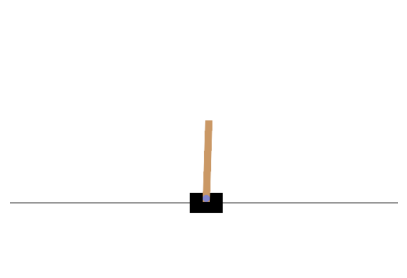

In [16]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()